# ViT for MNIST

It works well by making the images into patches and then turn them into embeddings to input to the transformer.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F

from tqdm.notebook import trange, tqdm

In [3]:
from google.colab import files
src = list(files.upload().values())[0]
open('patch_embeddings.py','wb').write(src)

Saving patch_embeddings.py to patch_embeddings.py


1269

In [4]:
from google.colab import files
src = list(files.upload().values())[0]
open('vit.py','wb').write(src)

Saving vit.py to vit.py


2861

## Data

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 49.9MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.81MB/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.56MB/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



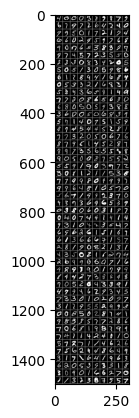

In [5]:
# Folder where the dataset is used
data_set_root = "../data"

# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 500 examples
number_of_examples = 500
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

## Model

In [6]:
from vit import VisionTransformer

# Size of the image.
# MNIST has 28x28 handwritten images
image_size = 28

# Patches
patch_size = 7

# Color channels
# MNIST uses grayscale images
in_channels = 1

# For MNIST there will be one class for each single digit
num_classes = 10

# Embedding dimension
embed_dim = 64
depth = 6
num_heads = 8
mlp_ratio = 4.0
dropout = 0.1


# Creating the ViT
model = VisionTransformer(
        image_size=image_size,
        patch_size=patch_size,
        in_channels=in_channels,
        num_classes=num_classes,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        mlp_ratio=mlp_ratio,
        dropout=dropout
    )

# Train

First setting the device of the model to be trained on

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
device

device(type='cpu')

Loading training data:

In [8]:
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)
test_loader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=False, num_workers=2)

In [9]:
opt = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)

Training loop:

In [11]:
# Training loop
num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # Progress bar for training
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backward and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{train_loss/total:.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    # Step the scheduler
    scheduler.step()

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss/len(train_loader):.3f}, '
          f'Train Acc: {100.*correct/total:.2f}%')
    print(f'Val Loss: {val_loss/len(test_loader):.3f}, '
          f'Val Acc: {100.*val_correct/val_total:.2f}%\n')

Epoch 1/4:   0%|          | 0/469 [00:00<?, ?it/s]


Epoch [1/4]
Train Loss: 0.240, Train Acc: 92.88%
Val Loss: 0.122, Val Acc: 96.29%



Epoch 2/4:   0%|          | 0/469 [00:00<?, ?it/s]


Epoch [2/4]
Train Loss: 0.132, Train Acc: 95.97%
Val Loss: 0.082, Val Acc: 97.54%



Epoch 3/4:   0%|          | 0/469 [00:00<?, ?it/s]


Epoch [3/4]
Train Loss: 0.098, Train Acc: 97.01%
Val Loss: 0.065, Val Acc: 97.95%



Epoch 4/4:   0%|          | 0/469 [00:00<?, ?it/s]


Epoch [4/4]
Train Loss: 0.079, Train Acc: 97.55%
Val Loss: 0.052, Val Acc: 98.40%



In [12]:
# Save the model
path = "model.pt"

torch.save(model.state_dict(), path)